In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.impute import SimpleImputer,KNNImputer

In [89]:
df = pd.read_csv("data/train.csv")
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


# Data Treatment

In [90]:
def treatment_analyser(df: pd.DataFrame) -> pd.DataFrame:
    df_tr = pd.concat([
    df.nunique(),
    df.nunique()/df.shape[0],
    df.isna().sum()/df.shape[0],
    df.dtypes,
    ],axis=1)
    df_tr.columns = ['unique','unique_rate','missing_pct','dtype']
    return df_tr

## Feature Removal
Further we can use feature engineering here, but will not be the case now

In [91]:
df_tr = treatment_analyser(df)
df_tr[(df_tr['dtype'] == object) & (df_tr['unique_rate'] > 0.1)]

,unique,unique_rate,missing_pct,dtype
PassengerId,8693,1.000000,0.000000,object
Cabin,6560,0.754630,0.022892,object
Name,8473,0.974692,0.023007,object


In [92]:
to_drop = ['PassengerId', 'Cabin', 'Name']
df = df.drop(to_drop,axis=1)

## Simple Inputer: Mode

In [93]:
df_tr = treatment_analyser(df)
df_tr[(df_tr['dtype'] == object) & (df_tr['unique_rate'] <= 0.1)]

,unique,unique_rate,missing_pct,dtype
HomePlanet,3,0.000345,0.023122,object
CryoSleep,2,0.000230,0.024963,object
Destination,3,0.000345,0.020936,object
VIP,2,0.000230,0.023352,object


In [94]:
to_mode = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for col in to_mode:
    mode_inputer = SimpleImputer(strategy='most_frequent')
    df[col] = mode_inputer.fit_transform(df[[col]])
df_tr = treatment_analyser(df)
df_tr.loc[to_mode]

,unique,unique_rate,missing_pct,dtype
HomePlanet,3,0.000345,0.0,object
CryoSleep,2,0.000230,0.0,object
Destination,3,0.000345,0.0,object
VIP,2,0.000230,0.0,object


In [95]:
df['CryoSleep'] = df['CryoSleep'].astype(bool)
df['VIP'] = df['VIP'].astype(bool)

In [96]:
df['HomePlanet'] = df['HomePlanet'].astype('category')
df['Destination'] = df['Destination'].astype('category')

## Simple Inputer: Median

In [97]:
df_tr = treatment_analyser(df)
df_tr.query('missing_pct > 0')

,unique,unique_rate,missing_pct,dtype
Age,80,0.009203,0.020591,float64
RoomService,1273,0.146440,0.020821,float64
FoodCourt,1507,0.173358,0.021051,float64
ShoppingMall,1115,0.128264,0.023927,float64
Spa,1327,0.152652,0.021051,float64
VRDeck,1306,0.150236,0.021627,float64


In [98]:
to_median = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in to_median:
    inputer = SimpleImputer(strategy='median')
    df[col] = inputer.fit_transform(df[[col]])
df_tr = treatment_analyser(df)
df_tr.loc[to_median]

,unique,unique_rate,missing_pct,dtype
Age,80,0.009203,0.0,float64
RoomService,1273,0.146440,0.0,float64
FoodCourt,1507,0.173358,0.0,float64
ShoppingMall,1115,0.128264,0.0,float64
Spa,1327,0.152652,0.0,float64
VRDeck,1306,0.150236,0.0,float64


## Outlier Check

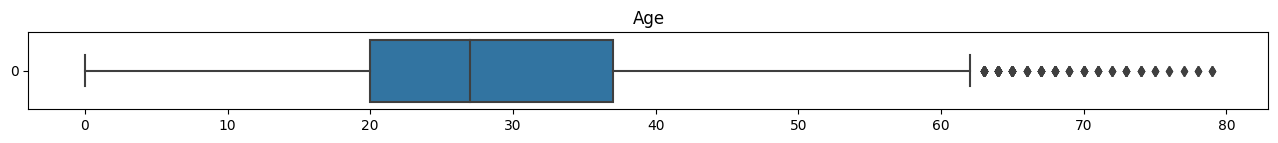

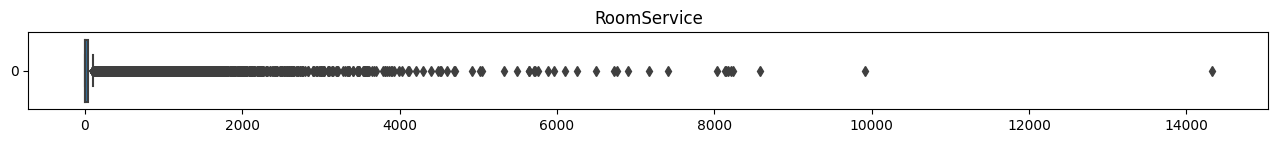

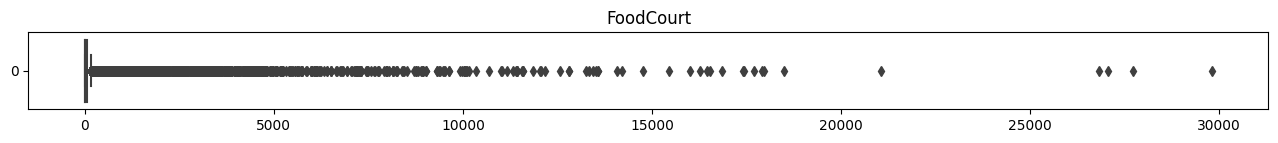

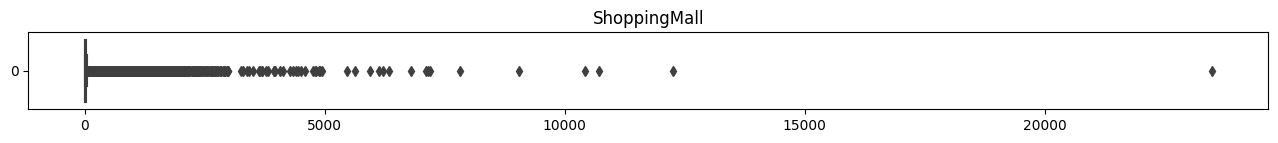

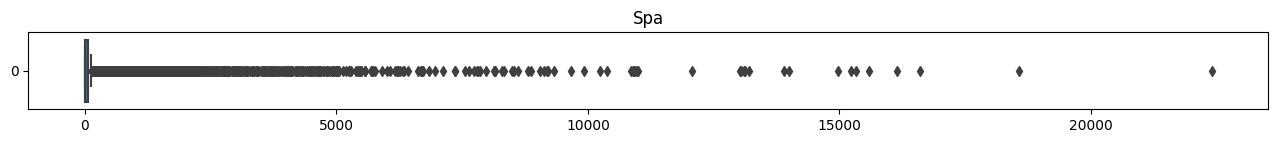

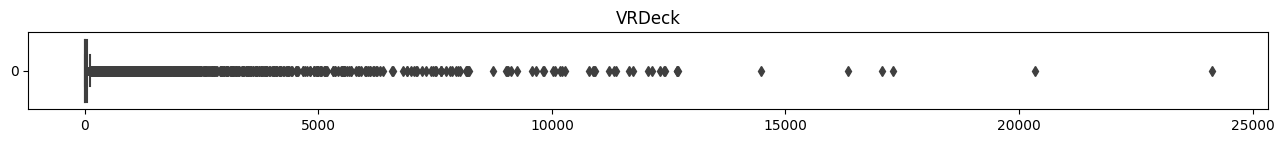

In [108]:
for col in to_median:
    plt.figure(figsize=(16,1))
    plt.title(col)
    sns.boxplot(df[col], orient='h')
    plt.show()

In [110]:
to_log = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in to_log:
    df[col] = np.log(df[col] + 1)

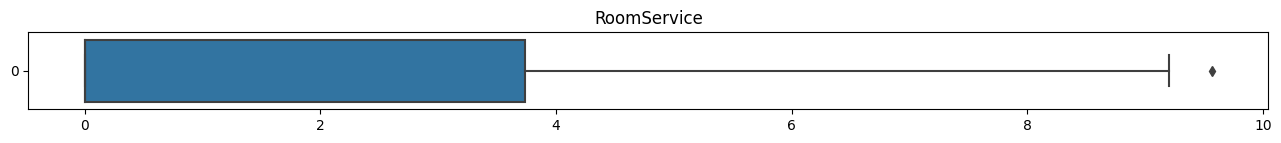

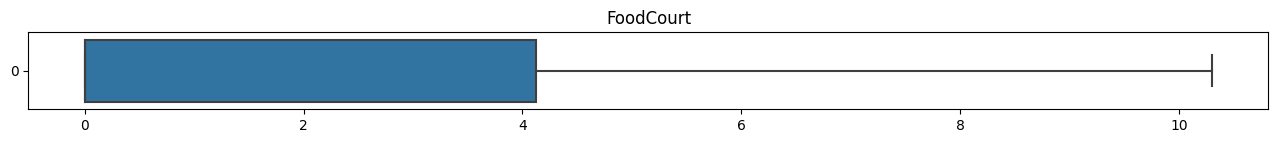

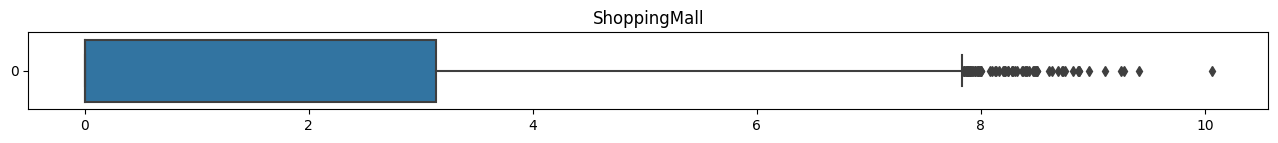

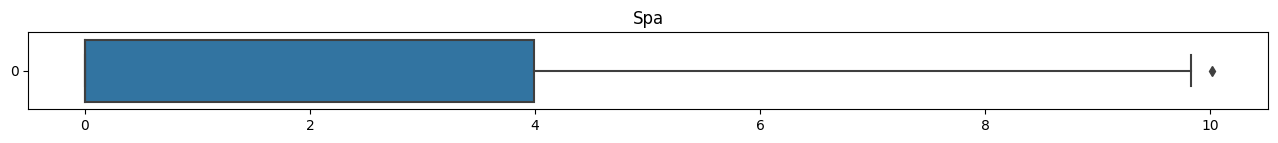

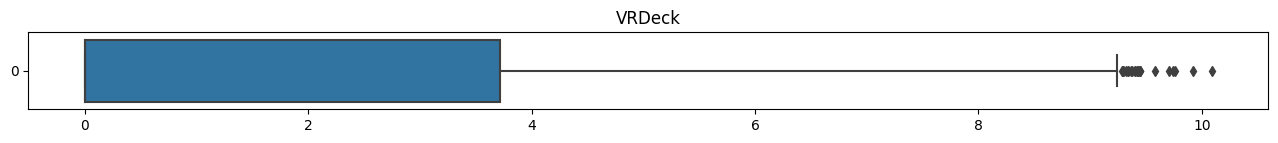

In [111]:
for col in to_log:
    plt.figure(figsize=(16,1))
    plt.title(col)
    sns.boxplot(df[col], orient='h')
    plt.show()

# Analytics

## Multivariate Analysis

In [112]:
df = pd.get_dummies(df, drop_first=True)

In [113]:
import itertools
y_var = 'Transported'
for x in itertools.combinations(df.columns.drop(y_var), 2):
    df[f'{x[0]}_{x[1]}'] = df[x[0]]*df[x[1]]
df = df.drop(df.columns[df.nunique() == 1].tolist(),axis=1)
df.head(2)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Europa,...,Spa_Destination_PSO J318.5-22,Spa_Destination_TRAPPIST-1e,VRDeck_HomePlanet_Europa,VRDeck_HomePlanet_Mars,VRDeck_Destination_PSO J318.5-22,VRDeck_Destination_TRAPPIST-1e,HomePlanet_Europa_Destination_PSO J318.5-22,HomePlanet_Europa_Destination_TRAPPIST-1e,HomePlanet_Mars_Destination_PSO J318.5-22,HomePlanet_Mars_Destination_TRAPPIST-1e
0,False,39.0,False,0.00000,0.000000,0.000000,0.000000,0.000000,False,1,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0,1,0,0
1,False,24.0,False,4.70048,2.302585,3.258097,6.309918,3.806662,True,0,...,0.0,6.309918,0.0,0.0,0.0,3.806662,0,0,0,0


In [137]:
stacked = df.corr().stack()
stacked[stacked > 0.9]

CryoSleep                                    CryoSleep                                      1.000000
Age                                          Age                                            1.000000
VIP                                          VIP                                            1.000000
                                             Age_VIP                                        0.954296
RoomService                                  RoomService                                    1.000000
                                                                                              ...   
HomePlanet_Europa_Destination_PSO J318.5-22  HomePlanet_Europa_Destination_PSO J318.5-22    1.000000
HomePlanet_Europa_Destination_TRAPPIST-1e    HomePlanet_Europa_Destination_TRAPPIST-1e      1.000000
HomePlanet_Mars_Destination_PSO J318.5-22    HomePlanet_Mars_Destination_PSO J318.5-22      1.000000
HomePlanet_Mars_Destination_TRAPPIST-1e      HomePlanet_Mars                               

In [138]:
import statsmodels.api as sm
Xtrain = df.drop(y_var,axis=1).astype(float)
Xtrain['const'] = 1
ytrain = df[[y_var]]
   
model = sm.Logit(ytrain, Xtrain).fit(method='bfgs')
model.summary()

         Current function value: 0.462530
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 41


c:\users\gonca\desktop\trabalho\resources\kaggle\.venv\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\users\gonca\desktop\trabalho\resources\kaggle\.venv\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
c:\users\gonca\desktop\trabalho\resources\kaggle\.venv\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\users\gonca\desktop\trabalho\resources\kaggle\.venv\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
c:\users\gonca\desktop\trabalho\resources\kaggle\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Transported   No. Observations:                 8693
Model:                          Logit   Df Residuals:                     8621
Method:                           MLE   Df Model:                           71
Date:                Sat, 22 Oct 2022   Pseudo R-squ.:                  0.3327
Time:                        17:36:10   Log-Likelihood:                -4020.8
converged:                      False   LL-Null:                       -6025.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
CryoSleep                                       0.4009      0.243      1.650      0.099      -0.075       0.877
Age                                            -0.0086      0.008     -1.136      0.256      -0.023       0.006
VIP                                             0.0113      1.662      0.007      0.995      -3.247       3.270
RoomService                                    -0.3740      0.049     -7.638      0.000      -0.470      -0.278
FoodCourt                                       0.2138      0.048      4.476      0.000       0.120       0.307
ShoppingMall                                    0.1559      0.045      3.478      0.001       0.068       0.244
Spa                                            -0.3195      0.051     -6.267      0.000      -0.419      -0.220
VRDeck                                         -0.2849      0.049     -5.759      0.000      -0.382      -0.188
HomePlanet_Europa                               0.3509      0.347      1.011      0.312      -0.330       1.031
HomePlanet_Mars                                 0.4399      0.307      1.432      0.152      -0.162       1.042
Destination_PSO J318.5-22                       0.0513      0.384      0.133      0.894      -0.702       0.804
Destination_TRAPPIST-1e                         0.0412      0.200      0.206      0.836      -0.350       0.432
CryoSleep_Age                                   0.0246      0.006      3.821      0.000       0.012       0.037
CryoSleep_VIP                                   0.0134      1.170      0.011      0.991      -2.281       2.307
CryoSleep_HomePlanet_Europa                     0.3320      0.303      1.095      0.273      -0.262       0.926
CryoSleep_HomePlanet_Mars                       0.3413      0.254      1.346      0.178      -0.156       0.838
CryoSleep_Destination_PSO J318.5-22            -0.0072      0.396     -0.018      0.986      -0.783       0.769
CryoSleep_Destination_TRAPPIST-1e               0.0956      0.242      0.394      0.693      -0.379       0.571
Age_VIP                                        -0.0152      0.019     -0.800      0.424      -0.052       0.022
Age_RoomService                                 0.0031      0.001      3.077      0.002       0.001       0.005
Age_FoodCourt                                2.363e-05      0.001      0.024      0.981      -0.002       0.002
Age_ShoppingMall                                0.0030      0.001      2.984      0.003       0.001       0.005
Age_Spa                                        -0.0009      0.001     -0.817      0.414      -0.003       0.001
Age_VRDeck                                   1.927e-05      0.001      0.018      0.986      -0.002       0.002
Age_HomePlanet_Europa                           0.0386      0.007      5.291      0.000       0.024       0.053
Age_HomePlanet_Mars                             0.0072      0.006      1.193      0.233      -0.005      

In [139]:
top_features = Xtrain.columns[model.pvalues < 0.06].drop('const',errors='ignore').to_list()
top_features

['RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'CryoSleep_Age',
 'Age_RoomService',
 'Age_ShoppingMall',
 'Age_HomePlanet_Europa',
 'Age_Destination_PSO J318.5-22',
 'Age_Destination_TRAPPIST-1e',
 'VIP_Spa',
 'RoomService_Spa',
 'RoomService_VRDeck',
 'RoomService_HomePlanet_Europa',
 'RoomService_HomePlanet_Mars',
 'RoomService_Destination_PSO J318.5-22',
 'FoodCourt_ShoppingMall',
 'FoodCourt_VRDeck',
 'FoodCourt_HomePlanet_Europa',
 'ShoppingMall_VRDeck',
 'ShoppingMall_HomePlanet_Europa',
 'Spa_VRDeck',
 'Spa_HomePlanet_Europa',
 'Spa_HomePlanet_Mars',
 'VRDeck_HomePlanet_Europa']

In [140]:
Xtrain = df[top_features].astype(float)
Xtrain['const'] = 1
ytrain = df[[y_var]]
   
model = sm.Logit(ytrain, Xtrain).fit(method='newton',maxiter=100)
model.summary()

Optimization terminated successfully.
         Current function value: 0.479333
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Transported   No. Observations:                 8693
Model:                          Logit   Df Residuals:                     8666
Method:                           MLE   Df Model:                           26
Date:                Sat, 22 Oct 2022   Pseudo R-squ.:                  0.3084
Time:                        17:36:26   Log-Likelihood:                -4166.8
converged:                       True   LL-Null:                       -6025.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
RoomService                              -0.3553      0.033    -10.772      0.000      -0.420      -0.291
FoodCourt                                 0.1878      0.021      8.987      0.000       0.147       0.229
ShoppingMall                              0.1404      0.030      4.634      0.000       0.081       0.200
Spa                                      -0.3999      0.022    -17.880      0.000      -0.444      -0.356
VRDeck                                   -0.3144      0.026    -12.092      0.000      -0.365      -0.263
CryoSleep_Age                             0.0304      0.003     10.330      0.000       0.025       0.036
Age_RoomService                           0.0013      0.001      1.419      0.156      -0.000       0.003
Age_ShoppingMall                          0.0015      0.001      1.785      0.074      -0.000       0.003
Age_HomePlanet_Europa                     0.0454      0.004     11.808      0.000       0.038       0.053
Age_Destination_PSO J318.5-22            -0.0272      0.004     -7.124      0.000      -0.035      -0.020
Age_Destination_TRAPPIST-1e              -0.0176      0.002     -8.348      0.000      -0.022      -0.013
VIP_Spa                                   0.0416      0.042      0.997      0.319      -0.040       0.123
RoomService_Spa                           0.0414      0.005      7.822      0.000       0.031       0.052
RoomService_VRDeck                        0.0291      0.005      5.692      0.000       0.019       0.039
RoomService_HomePlanet_Europa            -0.1821      0.043     -4.252      0.000      -0.266      -0.098
RoomService_HomePlanet_Mars              -0.0513      0.023     -2.228      0.026      -0.096      -0.006
RoomService_Destination_PSO J318.5-22     0.1130      0.040      2.847      0.004       0.035       0.191
FoodCourt_ShoppingMall                   -0.0247      0.005     -5.141      0.000      -0.034      -0.015
FoodCourt_VRDeck                         -0.0094      0.005     -1.842      0.066      -0.019       0.001
FoodCourt_HomePlanet_Europa               0.4053      0.042      9.636      0.000       0.323       0.488
ShoppingMall_VRDeck                      -0.0126      0.005     -2.467      0.014      -0.023      -0.003
ShoppingMall_HomePlanet_Europa            0.1441      0.044      3.283      0.001       0.058       0.230
Spa_VRDeck                                0.0531      0.005     10.246      0.000       0.043       0.063
Spa_HomePlanet_Europa                    -0.4087      0.039    -10.385      0.000      -0.486      -0.332
Spa_HomePlanet_Mars                      -0.0372      0.040     -0.933      0.351      -0.115       0.041
VRDeck_HomePlanet_Europa                 -0.3504      0.042     -8.366      0.000      -0.433      -0.268
const                                     0.7660      0.063     12.232      0.000       0.643       0.889
=============================================================

In [146]:
model.params[model.params.abs().sort_values(ascending=False).index]

const                                    0.766006
Spa_HomePlanet_Europa                   -0.408714
FoodCourt_HomePlanet_Europa              0.405317
Spa                                     -0.399924
RoomService                             -0.355326
VRDeck_HomePlanet_Europa                -0.350426
VRDeck                                  -0.314427
FoodCourt                                0.187827
RoomService_HomePlanet_Europa           -0.182110
ShoppingMall_HomePlanet_Europa           0.144067
ShoppingMall                             0.140426
RoomService_Destination_PSO J318.5-22    0.113010
Spa_VRDeck                               0.053130
RoomService_HomePlanet_Mars             -0.051331
Age_HomePlanet_Europa                    0.045363
VIP_Spa                                  0.041630
RoomService_Spa                          0.041369
Spa_HomePlanet_Mars                     -0.037200
CryoSleep_Age                            0.030434
RoomService_VRDeck                       0.029131


## Correlation Matrix

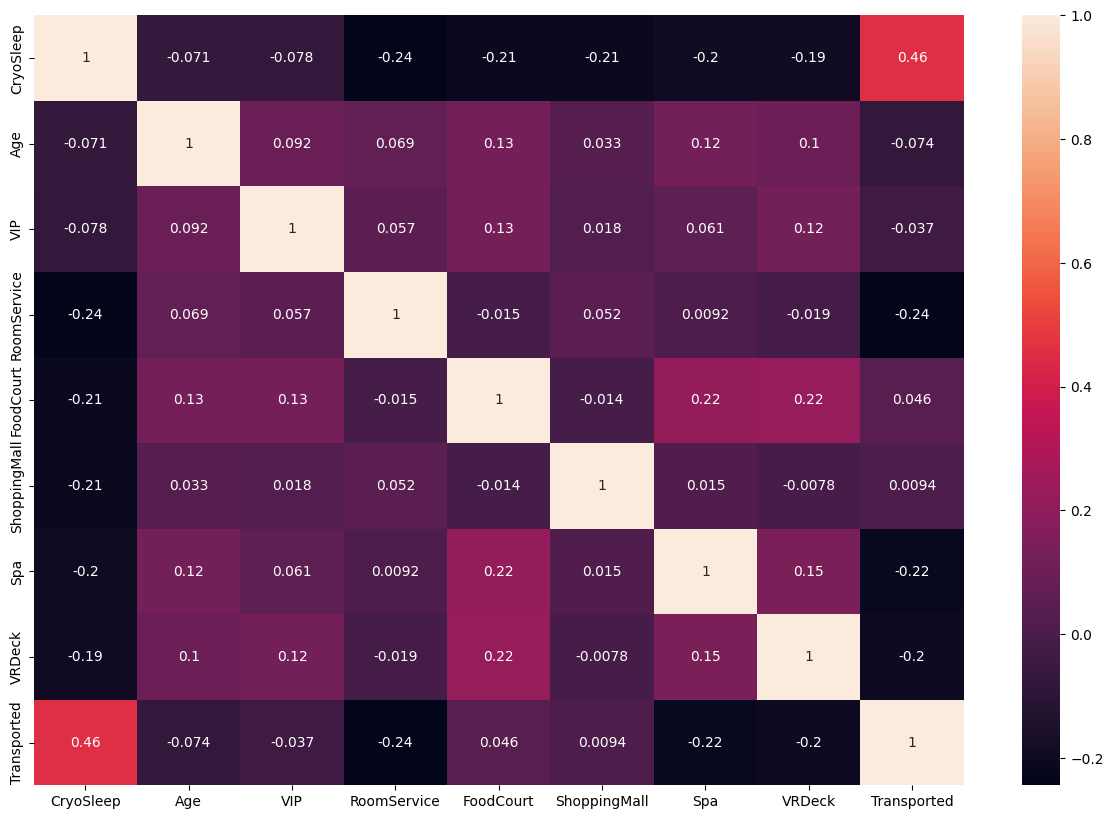

In [72]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

<AxesSubplot: xlabel='Spa', ylabel='VRDeck'>

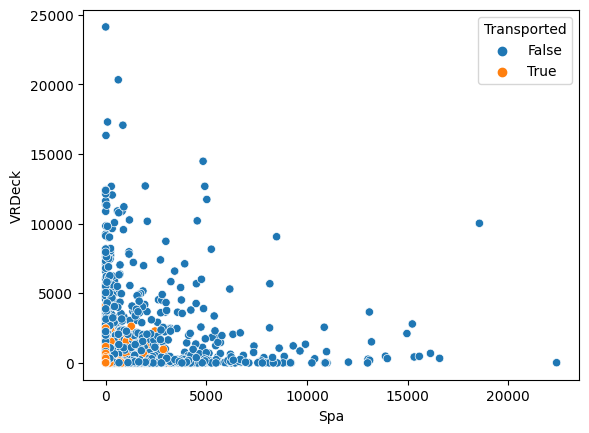

In [73]:
sns.scatterplot(data=df,x='Spa',y='VRDeck', hue='Transported')

<AxesSubplot: xlabel='RoomService', ylabel='VRDeck'>

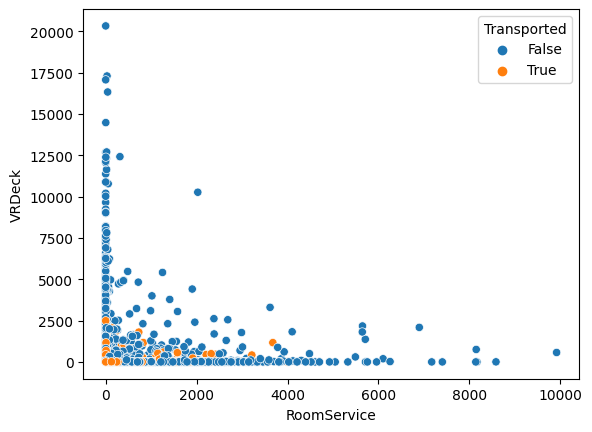

In [6]:
sns.scatterplot(data=df,x='RoomService',y='VRDeck', hue='Transported')

<AxesSubplot: xlabel='Age', ylabel='Count'>

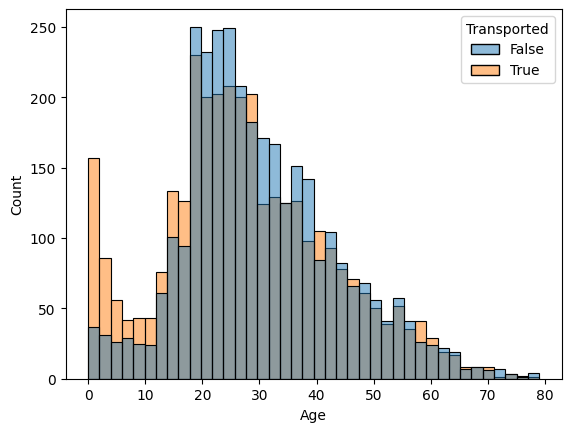

In [7]:
sns.histplot(data=df,x='Age',hue='Transported')

In [9]:
df[['HomePlanet','CryoSleep']]

PassengerId     6606
HomePlanet         3
CryoSleep          2
Cabin           5305
Destination        3
Age               80
VIP                2
RoomService     1093
FoodCourt       1293
ShoppingMall     984
Spa             1143
VRDeck          1106
Name            6590
Transported        2
dtype: int64